In [1]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

from collections import defaultdict
from itertools import combinations
from typing import List
from scipy import stats
from math import comb
import numpy as np

import pandas as pd
from typing import List, Dict, Tuple, Optional, Any

In [2]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [3]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1005,
            'bin_width': 1.0,
        },
    },
}

In [4]:
featurizer = SpectrumFeaturizer(config, mode='torch')

In [5]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [6]:
msn_dataset[0]

{'spec': Data(x=[14, 1005], edge_index=[2, 13]),
 'mol': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'precursor_mz': tensor(347.1489),
 'adduct': '[M+H]+',
 'identifier': '0000002_0000000',
 'mol_freq': tensor(1.)}

## Spectra node similarities

In [7]:
def summarize_similarity_distribution_aggregated(scores: List[float]) -> dict:
    """
    Return mean, std, median, count for a list of float scores,
    ignoring NaNs.
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "median": float(np.median(arr)),
        "count": len(arr)
    }

In [8]:
def summarize_similarity_distribution(scores: List[float], normality_alpha: float = 0.05) -> Dict[str, Any]:
    """
    Summarize similarity scores with statistics and normality tests.
    
    Parameters:
    - scores: List of similarity scores (floats)
    - normality_alpha: Significance level for normality tests
    
    Returns:
    - Dictionary with mean, std, median, count, normality test results
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    summary = {}
    if len(arr) == 0:
        summary = {
            "mean": np.nan,
            "std": np.nan,
            "median": np.nan,
            "count": 0,
            "shapiro_p": np.nan,
            "ks_p": np.nan,
            "is_normal": False
        }
        return summary
    
    # Basic statistics
    summary["mean"] = float(np.mean(arr))
    summary["std"] = float(np.std(arr))
    summary["median"] = float(np.median(arr))
    summary["count"] = len(arr)
    
    # Shapiro-Wilk Test (best for small to medium samples, but can be used with large)
    # Note: Shapiro-Wilk may not be suitable for very large datasets due to sensitivity
    if len(arr) >= 3 and len(arr) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(arr)
    else:
        # For large samples, Shapiro-Wilk is not recommended; use K-S test instead
        shapiro_p = np.nan
    
    # Kolmogorov-Smirnov Test against normal distribution
    # Estimate mean and std for the normal distribution
    ks_stat, ks_p = stats.kstest(arr, 'norm', args=(summary["mean"], summary["std"]))
    
    summary["shapiro_p"] = shapiro_p
    summary["ks_p"] = ks_p
    
    # Determine normality
    # If both tests (if applicable) fail to reject normality, consider it normal
    if shapiro_p >= normality_alpha or np.isnan(shapiro_p):
        is_normal = ks_p >= normality_alpha
    else:
        is_normal = False
    
    summary["is_normal"] = is_normal
    
    return summary

In [9]:
# def perform_statistical_tests(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
#     """
#     Perform statistical tests between all level pairs.
#     
#     Parameters:
#     - all_level_sims: Dict mapping level pairs to list of similarity scores
#     - alpha: Significance level
#     
#     Returns:
#     - List of dictionaries containing comparison results
#     """
#     # Summarize distributions and assess normality
#     summaries = {level_pair: summarize_similarity_distribution(vals) 
#                 for level_pair, vals in all_level_sims.items()}
#     
#     # Prepare for pairwise comparisons
#     level_pairs = list(all_level_sims.keys())
#     comparison_results = []
#     
#     # Total number of comparisons for Bonferroni
#     m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
#     if m > 0:
#         adjusted_alpha = alpha / m
#     else:
#         adjusted_alpha = alpha
#     
#     # Perform pairwise comparisons
#     for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
#         # Define comparison labels
#         group1_label = f"{lvlA1}-{lvlB1}"
#         group2_label = f"{lvlA2}-{lvlB2}"
#         
#         scores1 = all_level_sims[(lvlA1, lvlB1)]
#         scores2 = all_level_sims[(lvlA2, lvlB2)]
#         
#         summary1 = summaries[(lvlA1, lvlB1)]
#         summary2 = summaries[(lvlA2, lvlB2)]
#         
#         # Decide which test to use based on normality
#         if summary1["is_normal"] and summary2["is_normal"]:
#             # Perform Welch's t-test
#             t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
#             test_used = "Welch's t-test"
#         else:
#             # Perform Mann-Whitney U test
#             t_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
#             test_used = "Mann-Whitney U test"
#         
#         # Determine significance with Bonferroni correction
#         significant = p_val < adjusted_alpha
#         
#         comparison_results.append({
#             "Group 1": group1_label,
#             "Group 2": group2_label,
#             "Test Used": test_used,
#             "Statistic": t_stat,
#             "p-value": p_val,
#             "Significant": significant,
#             "Adjusted Alpha": adjusted_alpha
#         })
#     
#     return comparison_results

In [10]:

def report_comparison_results(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha", 
        "Significant"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))

In [11]:
def perform_statistical_tests_with_effect_sizes(all_level_sims: Dict[Tuple[int, int], List[float]], alpha: float = 0.05) -> List[Dict[str, Any]]:
    """
    Perform statistical tests between all level pairs and calculate effect sizes.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - alpha: Significance level
    
    Returns:
    - List of dictionaries containing comparison results including effect sizes
    """
    # Summarize distributions and assess normality
    summaries = {level_pair: summarize_similarity_distribution(vals) 
                for level_pair, vals in all_level_sims.items()}
    
    # Prepare for pairwise comparisons
    level_pairs = list(all_level_sims.keys())
    comparison_results = []
    
    # Total number of comparisons for Bonferroni
    m = comb(len(level_pairs), 2) if len(level_pairs) > 1 else 0
    if m > 0:
        adjusted_alpha = alpha / m
    else:
        adjusted_alpha = alpha
    
    # Perform pairwise comparisons
    for (lvlA1, lvlB1), (lvlA2, lvlB2) in combinations(level_pairs, 2):
        # Define comparison labels
        group1_label = f"{lvlA1}-{lvlB1}"
        group2_label = f"{lvlA2}-{lvlB2}"
        
        scores1 = all_level_sims[(lvlA1, lvlB1)]
        scores2 = all_level_sims[(lvlA2, lvlB2)]
        
        summary1 = summaries[(lvlA1, lvlB1)]
        summary2 = summaries[(lvlA2, lvlB2)]
        
        # Decide which test to use based on normality
        if summary1["is_normal"] and summary2["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(scores1, scores2, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary1["mean"] - summary2["mean"]
            pooled_var = ((summary1["std"]**2) / summary1["count"] + (summary2["std"]**2) / summary2["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            u_stat, p_val = stats.mannwhitneyu(scores1, scores2, alternative='two-sided')
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            n1 = len(scores1)
            n2 = len(scores2)
            rbc = 1 - (2 * u_stat) / (n1 * n2)
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha
        
        comparison_results.append({
            "Group 1": group1_label,
            "Group 2": group2_label,
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    return comparison_results

def report_comparison_results_with_effect_sizes(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results with effect sizes in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    # Rearrange columns for clarity
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha",
        "Significant",
        "Effect Size",
        "Effect Size Type"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    # Display the DataFrame
    print(df.to_string(index=False))

In [24]:
def compare_target_group_against_others(
    all_level_sims: Dict[Tuple[int, int], List[float]],
    target_level_pair: Tuple[int, int],
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare the target level pair's similarity scores against all other level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - target_level_pair: Tuple indicating the target level pair (e.g., (2,2))
    - alpha: Significance level
    
    Returns:
    - Pandas DataFrame with comparison results
    """
    target_scores = all_level_sims.get(target_level_pair, [])
    if not target_scores:
        raise ValueError(f"No similarity scores found for target level pair {target_level_pair}")
    
    # Summarize the target group
    summary_target = summarize_similarity_distribution(target_scores)
    
    comparison_results = []
    
    # Number of comparisons for Bonferroni correction
    other_level_pairs = [lp for lp in all_level_sims.keys() if lp != target_level_pair]
    m = len(other_level_pairs)
    if m == 0:
        raise ValueError("No other level pairs to compare against.")
    adjusted_alpha = alpha / m  # Bonferroni correction
    
    # Iterate over all other level pairs
    for level_pair in other_level_pairs:
        other_scores = all_level_sims[level_pair]
        summary_other = summarize_similarity_distribution(other_scores)
        
        # Decide which test to use based on normality
        if summary_target["is_normal"] and summary_other["is_normal"]:
            # Perform Welch's t-test
            t_stat, p_val = stats.ttest_ind(target_scores, other_scores, equal_var=False, nan_policy='omit')
            test_used = "Welch's t-test"
            # Calculate Cohen's d
            mean_diff = summary_target["mean"] - summary_other["mean"]
            pooled_var = ((summary_target["std"]**2) / summary_target["count"] + 
                         (summary_other["std"]**2) / summary_other["count"])
            pooled_std = np.sqrt(pooled_var)
            cohen_d = mean_diff / pooled_std
            effect_size = cohen_d
            effect_size_label = "Cohen's d"
        else:
            # Perform Mann-Whitney U test
            try:
                u_stat, p_val = stats.mannwhitneyu(target_scores, other_scores, alternative='two-sided')
            except ValueError as e:
                # Handle cases where all values are identical
                u_stat, p_val = np.nan, np.nan
            test_used = "Mann-Whitney U test"
            # Calculate Rank-Biserial Correlation as effect size
            if not np.isnan(u_stat):
                n1 = len(target_scores)
                n2 = len(other_scores)
                rbc = 1 - (2 * u_stat) / (n1 * n2)
            else:
                rbc = np.nan
            effect_size = rbc
            effect_size_label = "Rank-Biserial Correlation"
        
        # Determine significance with Bonferroni correction
        significant = p_val < adjusted_alpha if not np.isnan(p_val) else False
        
        comparison_results.append({
            "Target Group": f"{target_level_pair}",
            "Compared Group": f"{level_pair}",
            "Test Used": test_used,
            "Statistic": t_stat if test_used == "Welch's t-test" else u_stat,
            "p-value": p_val,
            "Adjusted Alpha": adjusted_alpha,
            "Significant": significant,
            "Effect Size": effect_size,
            "Effect Size Type": effect_size_label
        })
    
    # Convert to DataFrame for better readability
    df_results = pd.DataFrame(comparison_results)
    
    # Sort by p-value
    df_results = df_results.sort_values(by="p-value")
    
    return df_results

## Comparing results

In [12]:
from massspecgym.tools.data import (compute_cosine_hungarian_score, compute_pairwise_similarity_by_mslevel, compute_same_level_similarity_limited,compute_ancestor_descendant_similarity, compute_sibling_similarity, random_node_pairs)

from massspecgym.tools.plots import plot_histograms, plot_histograms_by_level_pairs
from massspecgym.tools.io import load_embeddings


In [13]:
# Your existing analysis code
# For normal similarity function (hungarian_fn)
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)


In [14]:
# MS-Level Pair Analysis (hungarian_fn based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [32]:
# # Print average for each level pair
# for level_pair, vals in all_level_sims_hung.items():
#     stats_lv = summarize_similarity_distribution(vals)
#     print(f"Level pair {level_pair} -> {stats_lv}")

In [34]:
# # Summarize and perform statistical tests for hungarian_fn similarities
# print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
# comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
# report_comparison_results_with_effect_sizes(comparison_results_hung)

In [17]:
# Limited MS2<->MS2 similarities (hungarian_fn)
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500
)

In [18]:
# stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
# print("\nMS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)


MS2<->MS2 (Hungarian) limited stats: {'mean': 0.021037320229887746, 'std': 0.05798625485692401, 'median': 0.004837391338501844, 'count': 500, 'shapiro_p': 8.685243725814407e-39, 'ks_p': 5.3633244413945976e-58, 'is_normal': False}


In [29]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)


In [31]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (4, 4) -> {'mean': 0.24120319032465876, 'std': 0.32201527994996815, 'median': 0.0727915126063649, 'count': 250039, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 5) -> {'mean': 0.07193860604153023, 'std': 0.11487458429477933, 'median': 0.02658169835400203, 'count

In [33]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001111         True    -0.528622 Rank-Biserial Correlation
    4-5     5-5 Mann-Whitney U test 1.104435e+09  0.000000e+00        0.001111         True     0.201598 Rank-Biserial Correlation
    3-5     5-5 Mann-Whitney U test 6.045751e+08  0.000000e+00        0.001111         True     0.303949 Rank-Biserial Correlation
    3-5     4-5 Mann-Whitney U test 3.736132e+09  0.000000e+00        0.001111         True     0.112870 Rank-Biserial Correlation
    2-5     5-5 Mann-Whitney U test 9.509983e+07  0.000000e+00        0.001111         True     0.451280 Rank-Biserial Correlation
    2-5     4-5 Mann-Whitney U test 5.945492e+08  0.000000e+00        0.001111         True     0.292489 Rank-Biserial Correlation
    2-5     3-5 Man

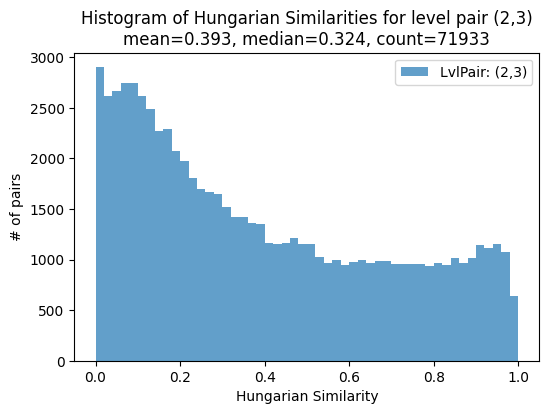

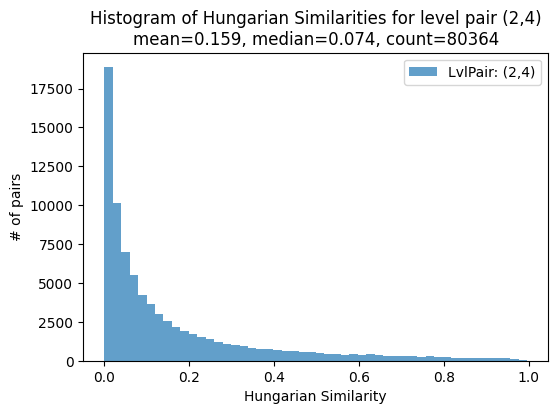

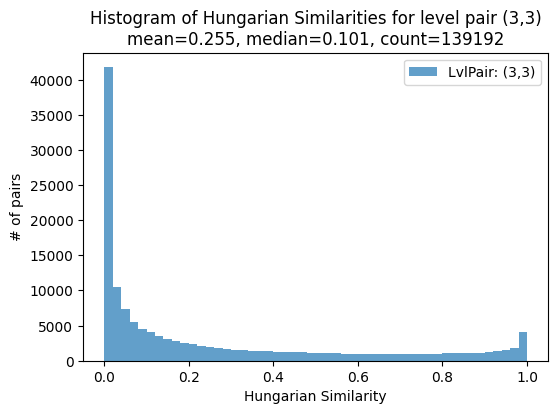

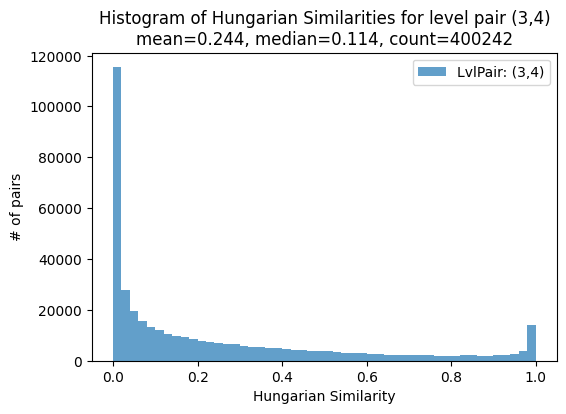

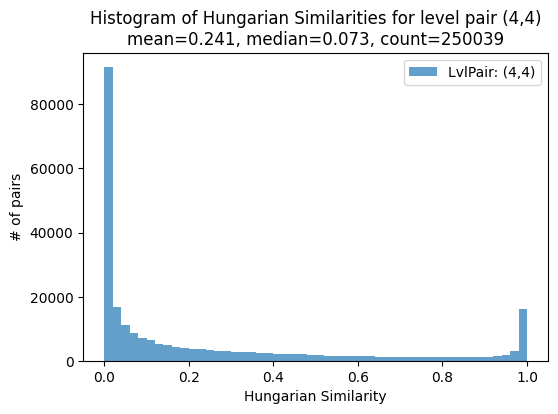

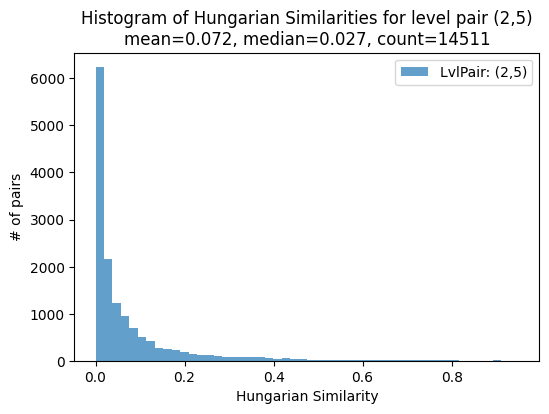

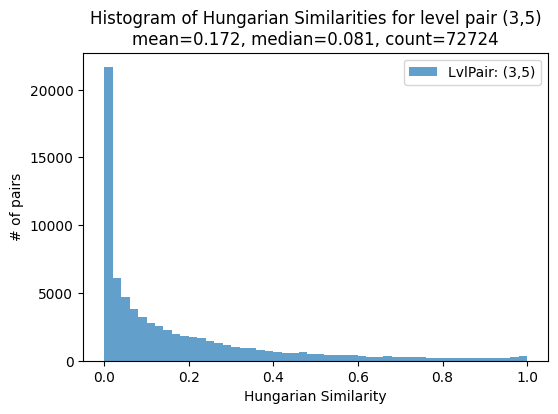

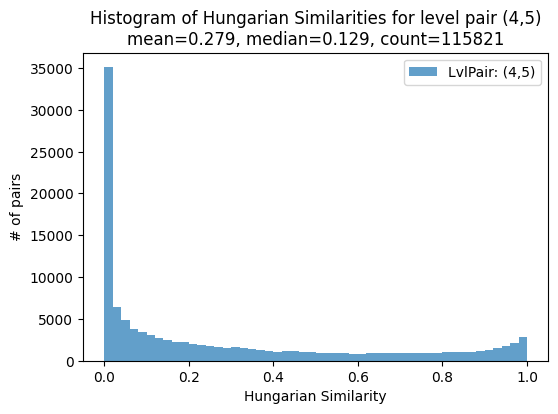

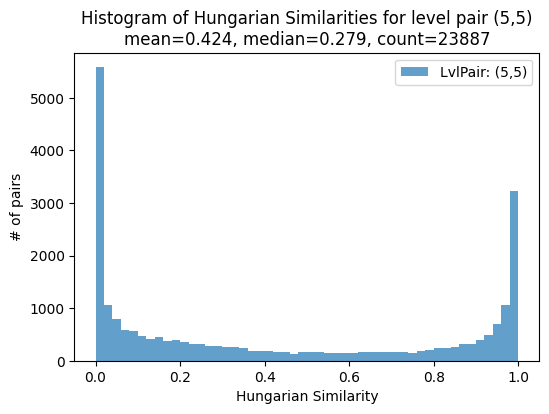

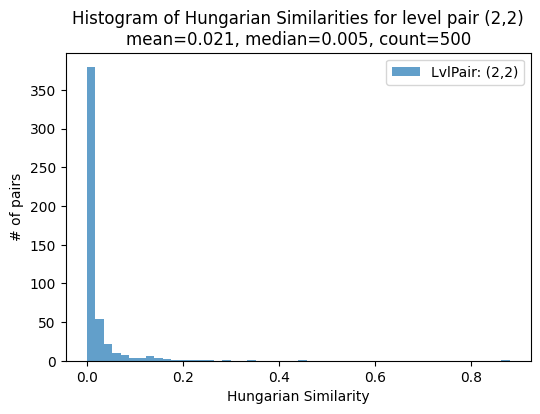

In [35]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="Hungarian")

## DreaMS

In [36]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [37]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=True, sim_fn=None, embeddings_dict=embeddings_dict
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims_hung:
            all_level_sims_hung[(lvlA, lvlB)] = []
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [38]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,
    embeddings_dict=embeddings_dict,
    max_pairs=5000 
)

In [39]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)

In [40]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933, 'shapiro_p': nan, 'ks_p': 1.3672070184790992e-77, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364, 'shapiro_p': nan, 'ks_p': 2.472693430814236e-73, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153, 'count': 400242, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (4, 4) -> {'mean': 0.34772124886512756, 'std': 0.25415658950805664, 'median': 0.2987461984157562, 'count': 250039, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 5) -> {'mean': 0.21092155575752258, 'std': 0.12815092504024506, 

In [41]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.315303e+09  0.000000e+00        0.001111         True    -0.492972 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 5.400329e+08  0.000000e+00        0.001111         True    -0.551908 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 4.589233e+10  0.000000e+00        0.001111         True     0.082851 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 3.562181e+09  0.000000e+00        0.001111         True    -0.226665 Rank-Biserial Correlation
    3-4     4-5 Mann-Whitney U test 1.755883e+10  0.000000e+00        0.001111         True     0.242442 Rank-Biserial Correlation
    3-4     5-5 Mann-Whitney U test 2.386486e+09  0.000000e+00        0.001111         True     0.500766 Rank-Biserial Correlation
    3-4     2-2 Man

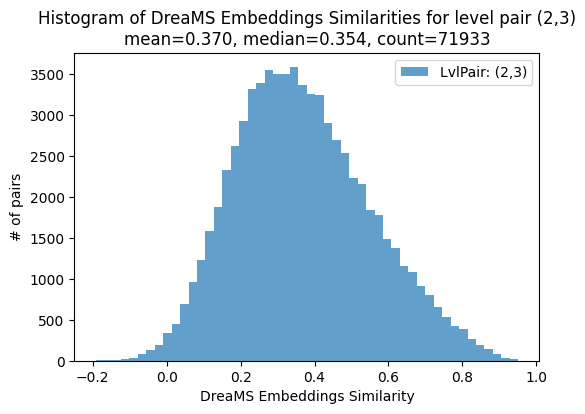

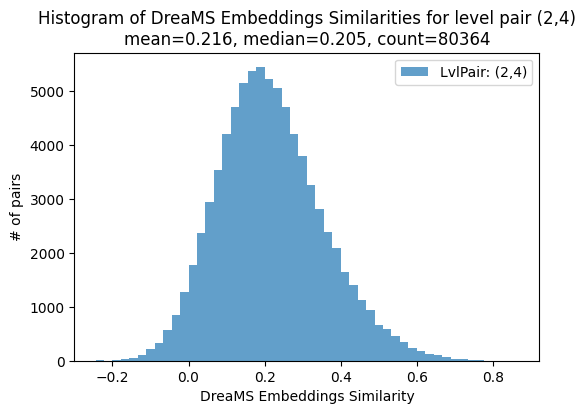

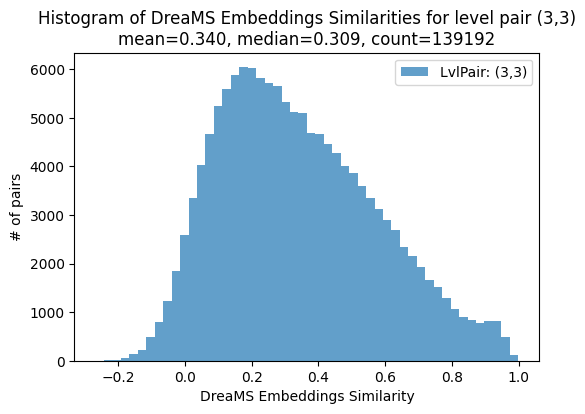

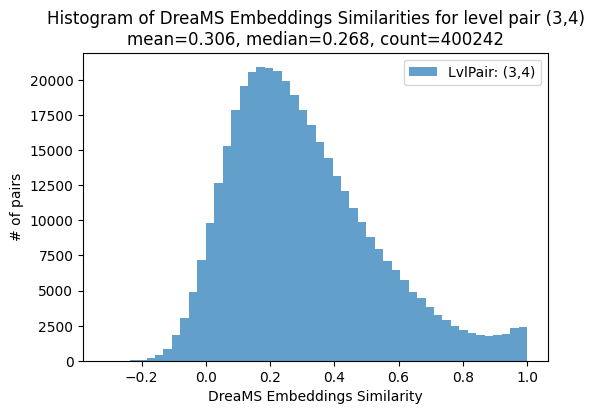

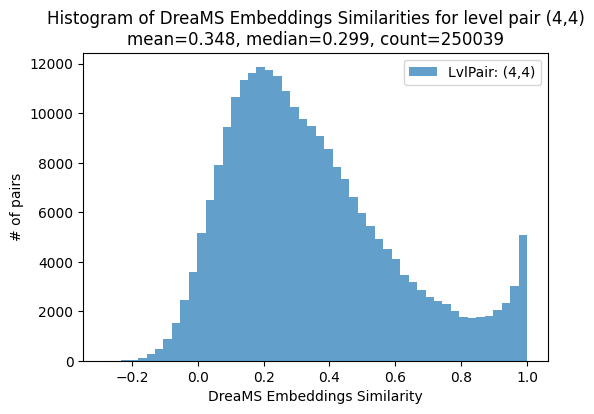

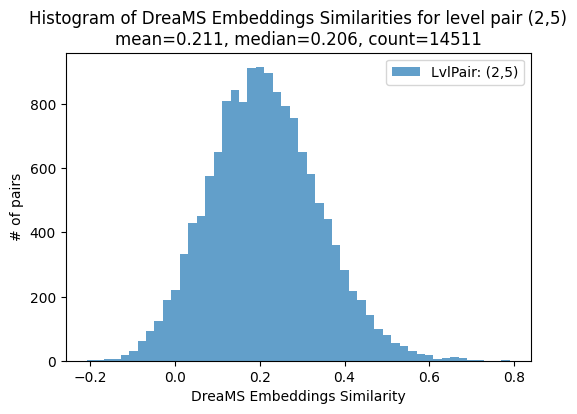

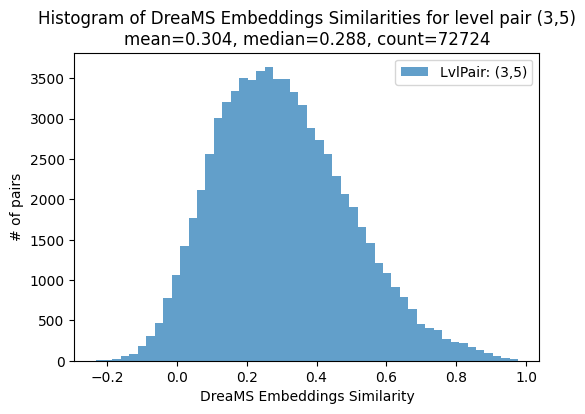

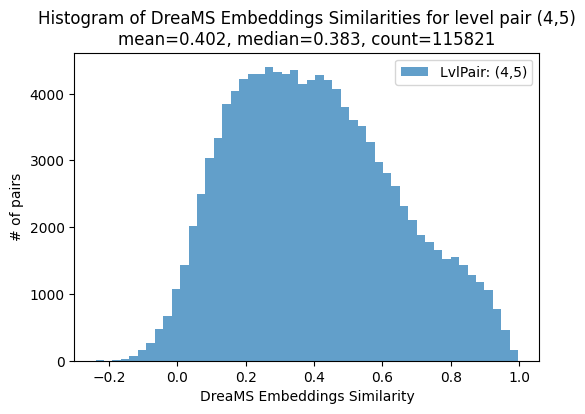

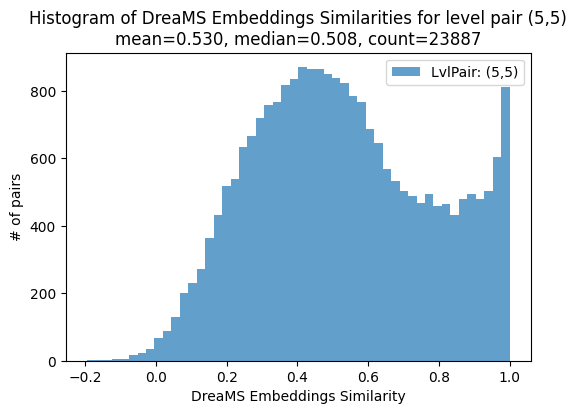

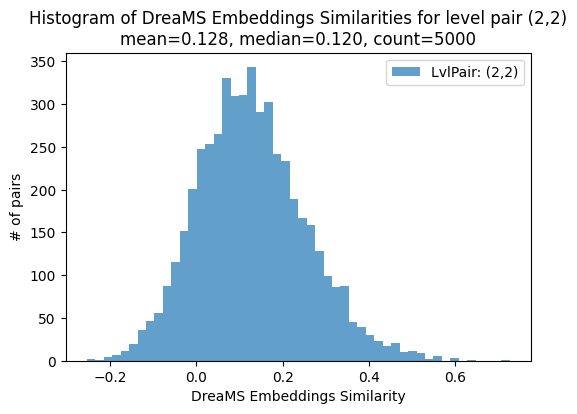

In [42]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="DreaMS Embeddings")

In [14]:
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

ad_sims_hung = []
sib_sims_hung = []
rand_sims_hung = []

In [15]:
for tree in msn_dataset.trees:
    # Anc-Desc
    sims = compute_ancestor_descendant_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    ad_sims_hung.extend(sims)

    # Siblings
    siblings = compute_sibling_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    sib_sims_hung.extend(siblings)

rand_sims_hung = random_node_pairs(msn_dataset, num_pairs=5000,
                                   use_embedding=False, sim_fn=hungarian_fn)

In [16]:
stats_ad_hung = summarize_similarity_distribution(ad_sims_hung)
stats_sib_hung = summarize_similarity_distribution(sib_sims_hung)
stats_rand_hung = summarize_similarity_distribution(rand_sims_hung)

print("Ancestor-Descendant (Hungarian Cosine) stats:", stats_ad_hung)
print("Sibling (Hungarian Cosine) stats:", stats_sib_hung)
print("Random pairs (Hungarian Cosine) stats:", stats_rand_hung)

Ancestor-Descendant (Hungarian Cosine) stats: {'mean': 0.41311503931629406, 'std': 0.2766341832752525, 'median': 0.358482554701118, 'count': 166808, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Sibling (Hungarian Cosine) stats: {'mean': 0.2600110815415143, 'std': 0.3069481175822487, 'median': 0.11463458831076889, 'count': 173661, 'shapiro_p': nan, 'ks_p': 0.0, 'is_normal': False}
Random pairs (Hungarian Cosine) stats: {'mean': 0.02776404450850912, 'std': 0.08324445757657506, 'median': 0.0015620962330701858, 'count': 5000, 'shapiro_p': 8.093267018062923e-86, 'ks_p': 0.0, 'is_normal': False}


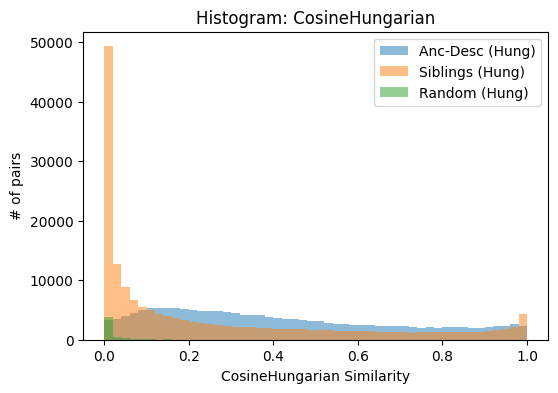

In [17]:
plot_histograms({
    "Anc-Desc (Hung)": ad_sims_hung,
    "Siblings (Hung)": sib_sims_hung,
    "Random (Hung)": rand_sims_hung
}, title="Histogram: CosineHungarian", xlabel="CosineHungarian Similarity")

In [18]:
# MS-Level Pair Analysis
all_level_sims = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims[(lvlA, lvlB)].extend(simvals)


In [22]:
# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution_aggregated(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.24120319032465876, 'std': 0.32201527994996815, 'median': 0.0727915126063649, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.07193860604153023, 'std': 0.11487458429477933, 'median': 0.02658169835400203, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.17168872250009667, 'std': 0.22198916240377284, 'median': 0.08056879358545516, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.27896573058598184, 'std': 0.3234083841746633, 'median': 0.12890938206511526, 'count': 1

In [19]:
# Perform statistical tests
comparison_results = perform_statistical_tests(all_level_sims, alpha=0.05)

# Report the results
report_comparison_results(comparison_results)

Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001389         True
    3-5     4-5 Mann-Whitney U test 3.736132e+09  0.000000e+00        0.001389         True
    2-5     5-5 Mann-Whitney U test 9.509983e+07  0.000000e+00        0.001389         True
    2-5     4-5 Mann-Whitney U test 5.945492e+08  0.000000e+00        0.001389         True
    2-5     3-5 Mann-Whitney U test 3.983101e+08  0.000000e+00        0.001389         True
    4-4     5-5 Mann-Whitney U test 2.233256e+09  0.000000e+00        0.001389         True
    4-4     4-5 Mann-Whitney U test 1.336197e+10  0.000000e+00        0.001389         True
    3-4     5-5 Mann-Whitney U test 3.752695e+09  0.000000e+00        0.001389         True
    3-4     3-5 Mann-Whitney U test 1.599715e+10  0.000000e+00        0.001389         True
    3-4     2-5 Mann-Whitney U test 3.800016e+09  0.000000e+00        0.001389  

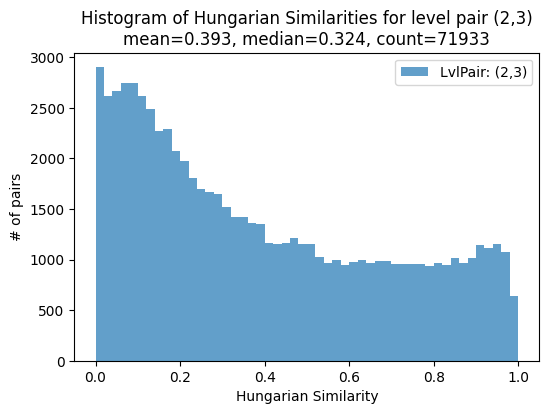

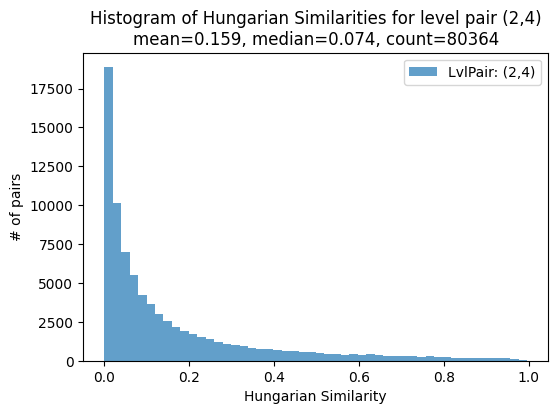

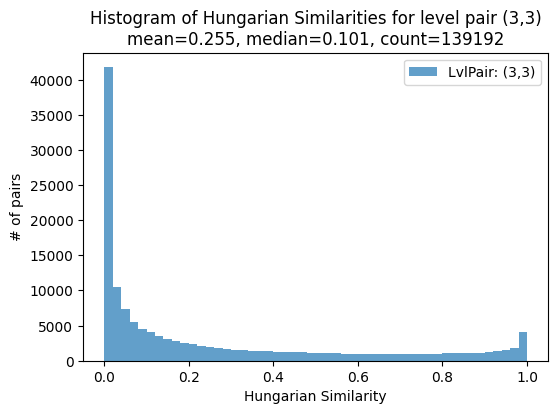

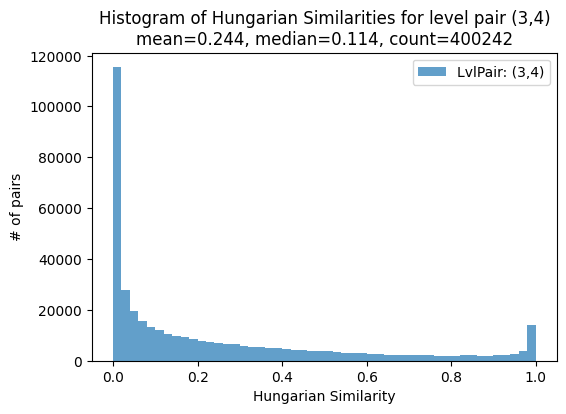

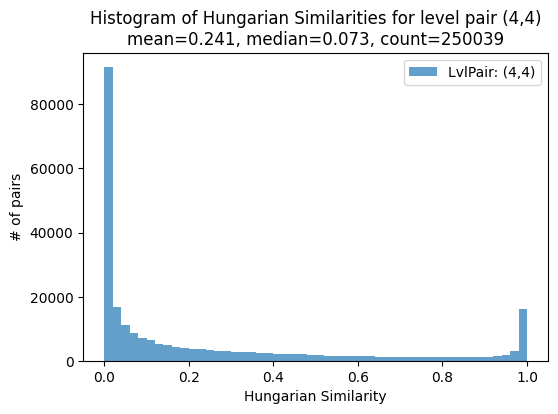

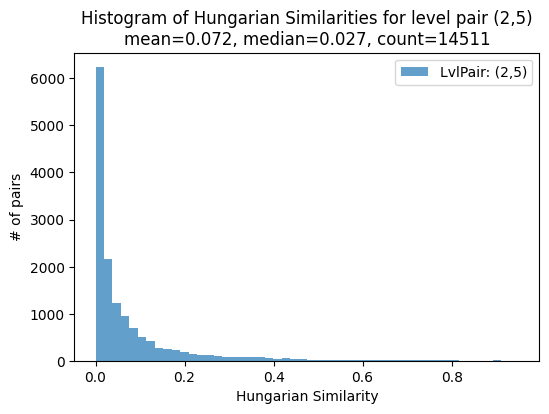

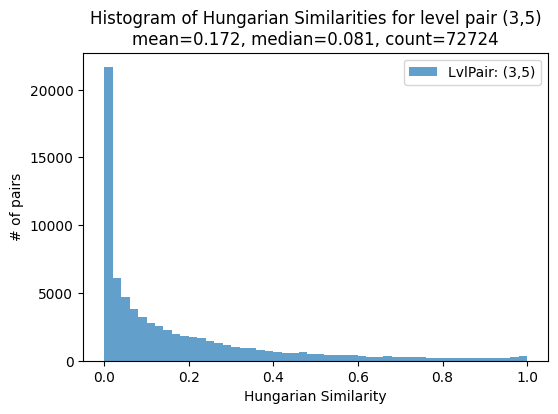

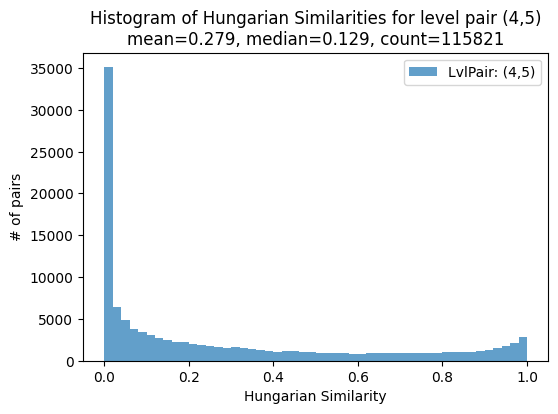

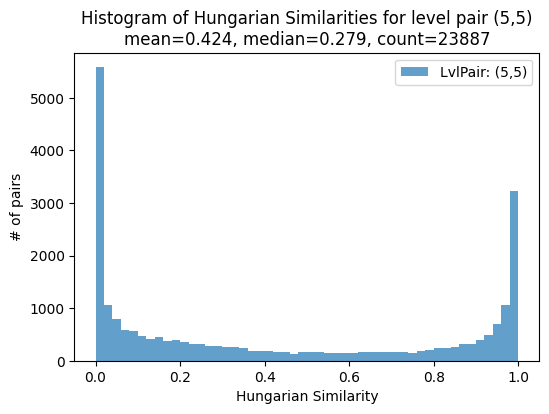

In [20]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims, mode="Hungarian")

In [25]:
# We want MS level 2 only
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500  
)

stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
print("MS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)

MS2<->MS2 (Hungarian) limited stats: {'mean': 0.022353537793716256, 'std': 0.05934879960602478, 'median': 0.00456160157323064, 'count': 500}


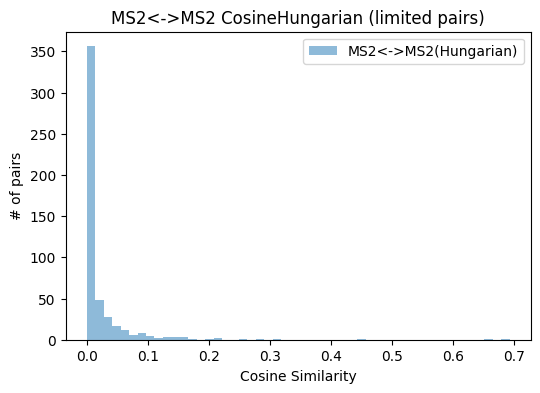

In [26]:
plot_histograms({
    "MS2<->MS2(Hungarian)": ms2_sims_hung
}, title="MS2<->MS2 CosineHungarian (limited pairs)", xlabel="Cosine Similarity")

## DreaMS embedding

In [27]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [35]:
# 1) Ancestor-Descendant
embed_ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_ad_sims.extend(sims)
stats_ad = summarize_similarity_distribution(embed_ad_sims)

# 2) Siblings
embed_sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_sib_sims.extend(sims)
stats_sib = summarize_similarity_distribution(embed_sib_sims)

# 3) Random pairs
embed_rand_sims = random_node_pairs(
    msn_dataset,
    num_pairs=5000,
    use_embedding=True,
    sim_fn=None,              
    embeddings_dict=embeddings_dict
)
stats_rand = summarize_similarity_distribution(embed_rand_sims)

In [36]:
print("Ancestor-Descendant (DreaMS) stats:", stats_ad)
print("Sibling (DreaMS) stats:", stats_sib)
print("Random pairs (DreaMS) stats:", stats_rand)

Ancestor-Descendant (DreaMS) stats: {'mean': 0.3994917571544647, 'std': 0.19029690325260162, 'median': 0.3847954273223877, 'count': 166808}
Sibling (DreaMS) stats: {'mean': 0.350467711687088, 'std': 0.2291901558637619, 'median': 0.3284909129142761, 'count': 173661}
Random pairs (DreaMS) stats: {'mean': 0.11952214688062668, 'std': 0.12343708425760269, 'median': 0.10753466188907623, 'count': 5000}


In [37]:
# TODO if one is signif better
stats_ad

{'mean': 0.3994917571544647,
 'std': 0.19029690325260162,
 'median': 0.3847954273223877,
 'count': 166808}

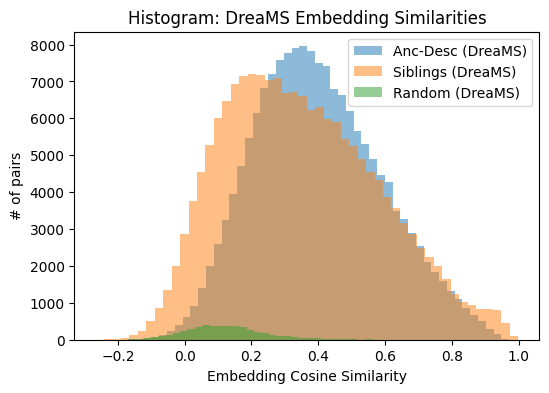

In [30]:
plot_histograms({
    "Anc-Desc (DreaMS)": embed_ad_sims,
    "Siblings (DreaMS)": embed_sib_sims,
    "Random (DreaMS)": embed_rand_sims
},
title="Histogram: DreaMS Embedding Similarities",
xlabel="Embedding Cosine Similarity")


In [31]:
# MS-Level Pair Analysis (embedding-based)
all_level_sims = {}
for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims:
            all_level_sims[(lvlA, lvlB)] = []
        all_level_sims[(lvlA, lvlB)].extend(simvals)

# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.34772124886512756, 'std': 0.25415658950805664, 'median': 0.2987461984157562, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.21092155575752258, 'std': 0.12815092504024506, 'median': 0.20595784485340118, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.3043021857738495, 'std': 0.1910751909017563, 'median': 0.2875922918319702, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.40176916122436523, 'std': 0.23634786903858185, 'median': 0.3825491964817047, 'count': 1158

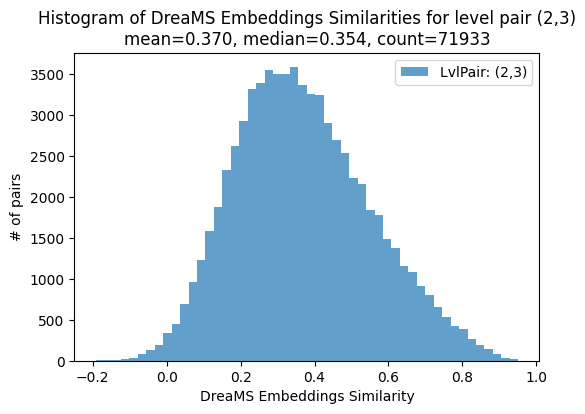

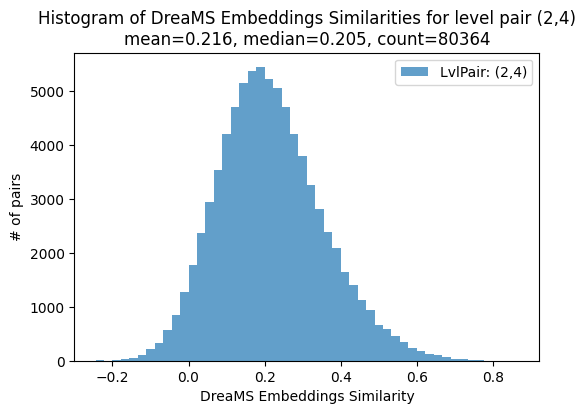

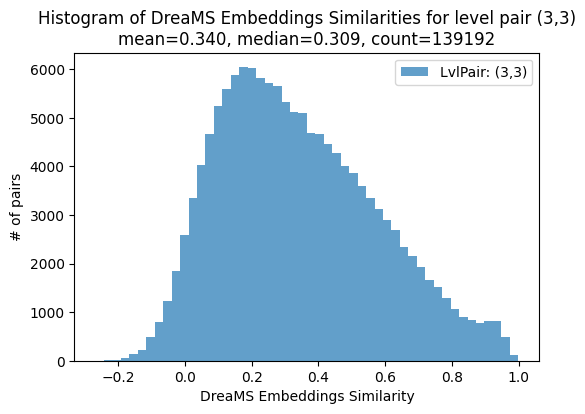

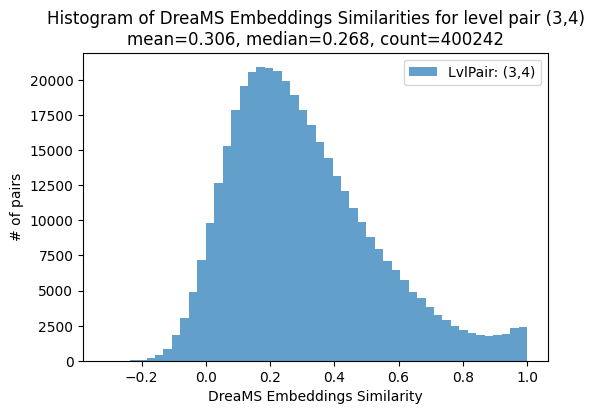

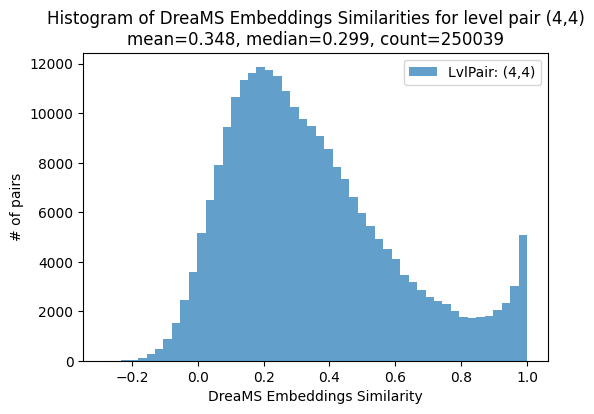

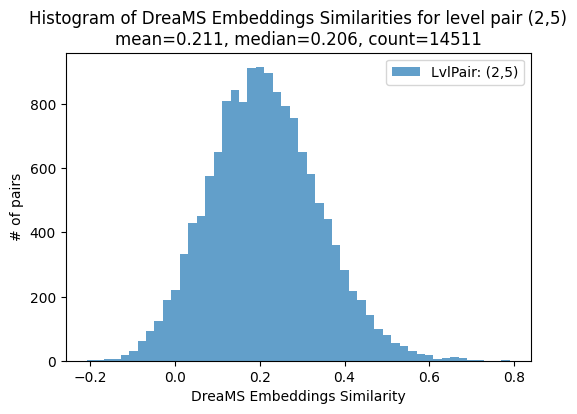

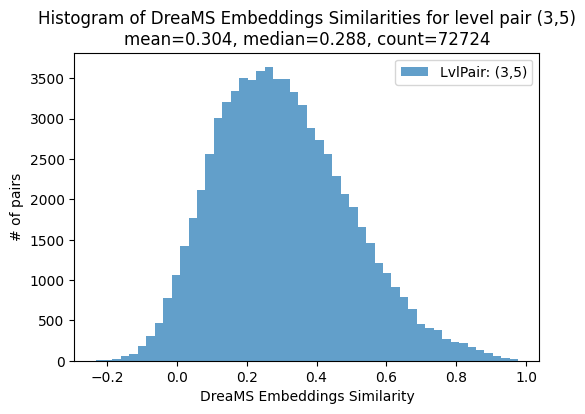

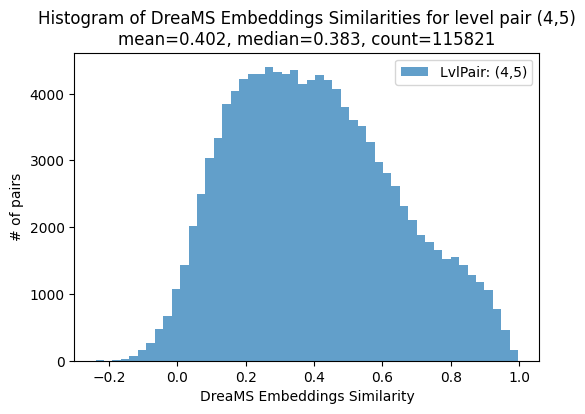

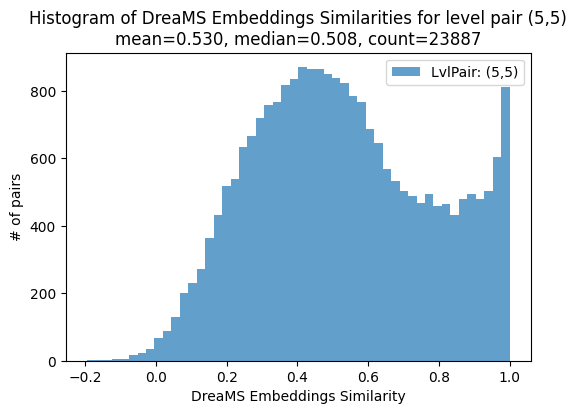

In [32]:
# Plot each level pair in a separate figure
plot_histograms_by_level_pairs(all_level_sims, mode="DreaMS Embeddings")

In [33]:
# MS2 <-> MS2 (embedding-based) with limited pairs
ms2_sims_emb = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,  # => dreams_embedding_similarity
    embeddings_dict=embeddings_dict,
    max_pairs=5000   
)
stats_ms2_emb = summarize_similarity_distribution(ms2_sims_emb)
print("MS2<->MS2 (DreaMS embeddings) limited stats:", stats_ms2_emb)

MS2<->MS2 (DreaMS embeddings) limited stats: {'mean': 0.12317246198654175, 'std': 0.12449826300144196, 'median': 0.11809742450714111, 'count': 5000}


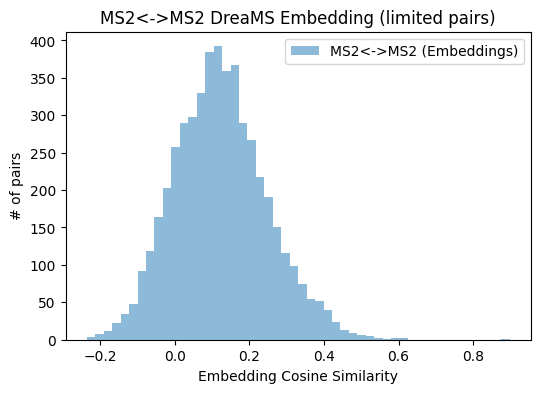

In [34]:
plot_histograms({
    "MS2<->MS2 (Embeddings)": ms2_sims_emb
}, title="MS2<->MS2 DreaMS Embedding (limited pairs)", xlabel="Embedding Cosine Similarity")